# Fully Convolutional Networks (inference)

In [1]:
import numpy as np
import cv2
import skimage as ski
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

### Load COCO dataset

In [2]:
path_to_coco = '../../coco/'
path_to_ann = path_to_coco + 'annotations/instances_val2014.json'
path_to_img = path_to_coco + 'images/val2014/'

from pycocotools.coco import COCO
coco=COCO(path_to_ann)

loading annotations into memory...
Done (t=4.79s)
creating index...
index created!


In [3]:
cats = coco.loadCats(coco.getCatIds())
catId_toId = {}
for i, cat in enumerate(cats):
    catId_toId[cat['id']] = i + 1
catIds = coco.getCatIds(catNms=['cat'])
imgIds = coco.getImgIds(catIds=catIds)

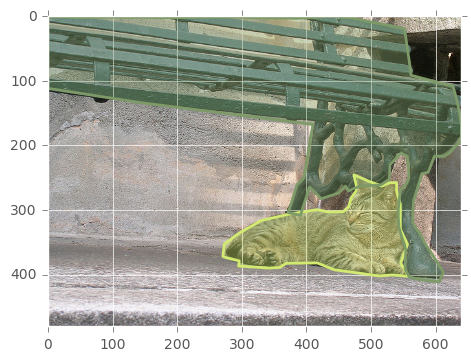

In [4]:
cocoImg = coco.loadImgs(imgIds[520])[0]
img = cv2.imread(path_to_img + cocoImg['file_name'], cv2.IMREAD_COLOR)
plt.imshow(img[:,:,[2,1,0]])
annIds = coco.getAnnIds(imgIds=cocoImg['id'], iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [5]:
from skimage import draw

def create_label(anns, in_size, out_size):
    h_in, w_in = in_size
    label = np.zeros((out_size,out_size), dtype=np.int32)
    
    for ann in anns:
        cat = catId_toId[ann['category_id']]
        
        # polygon to label
        if type(ann['segmentation']) == list:
            segs = ann['segmentation']
            for seg in segs:
                p = np.array(seg).reshape((len(seg)/2, 2)).transpose()
                p[0] *= (out_size + 1) / float(w_in)
                p[1] *= (out_size + 1) / float(h_in)
                rr, cc = ski.draw.polygon(
                    y=p[1]-1, x=p[0]-1, shape=(out_size,out_size))
                # -1 for overlapped area, 0 for BG, n for class id
                label[rr, cc] = np.fabs(label[rr, cc])
                label[rr, cc] = np.clip(label[rr, cc], a_min=0, a_max=1)
                label[rr, cc] = (1-label[rr, cc]) * (cat+1) - 1
                
        # RLE to label
        #else:
            #if type(ann['segmentation']['counts']) == list:
            #    rle = mask.frPyObjects([ann['segmentation']], h, w)
            #else:
            #    rle = [ann['segmentation']]
            #m = mask.decode(rle)
            #print(i, 'isCrowd')
            #mask = m[:,:,0] * cat
    return label

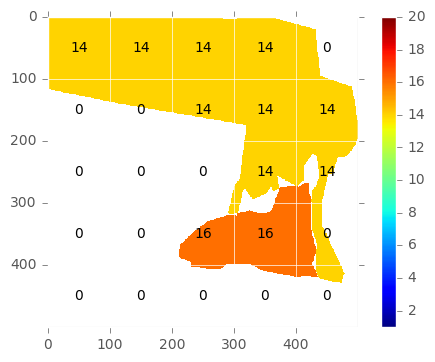

In [6]:
import matplotlib.cm as cm
cmap = cm.get_cmap('jet')
cmap.set_under('w')
label = create_label(anns=anns, in_size=img.shape[:2], out_size=500)
n_cat = len(cats) + 1
plt.imshow(label, cmap, vmin=1, vmax=20, interpolation='none')
plt.colorbar()
for (i,j), _ in np.ndenumerate(np.zeros((5,5))):
    plt.text(100*j+50,100*i+50,label[100*i+50,100*j+50],ha='center',va='center')

### Load Chainer and the dependencies

In [7]:
import chainer
from chainer import cuda
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
from chainer import serializers

In [8]:
class FCN(chainer.Chain):

    def __init__(self):
        super(self.__class__, self).__init__(
            conv1_1=L.Convolution2D(3, 64, ksize=3, stride=1, pad=100),
            conv1_2=L.Convolution2D(64, 64, ksize=3, stride=1, pad=1),

            conv2_1=L.Convolution2D(64, 128, ksize=3, stride=1, pad=1),
            conv2_2=L.Convolution2D(128, 128, ksize=3, stride=1, pad=1),

            conv3_1=L.Convolution2D(128, 256, ksize=3, stride=1, pad=1),
            conv3_2=L.Convolution2D(256, 256, ksize=3, stride=1, pad=1),
            conv3_3=L.Convolution2D(256, 256, ksize=3, stride=1, pad=1),

            conv4_1=L.Convolution2D(256, 512, ksize=3, stride=1, pad=1),
            conv4_2=L.Convolution2D(512, 512, ksize=3, stride=1, pad=1),
            conv4_3=L.Convolution2D(512, 512, ksize=3, stride=1, pad=1),

            conv5_1=L.Convolution2D(512, 512, ksize=3, stride=1, pad=1),
            conv5_2=L.Convolution2D(512, 512, ksize=3, stride=1, pad=1),
            conv5_3=L.Convolution2D(512, 512, ksize=3, stride=1, pad=1),

            fc6=L.Convolution2D(512, 4096, ksize=7, stride=1, pad=0),
            fc7=L.Convolution2D(4096, 4096, ksize=1, stride=1, pad=0),
            
            # fc7
            score_fr=L.Convolution2D(4096, 81, ksize=1, stride=1, pad=0),
            upscore2=L.Deconvolution2D(81, 81, ksize=4, stride=2, pad=0, nobias=True),
            
            # pool4
            score_pool4=L.Convolution2D(512, 81, ksize=1, stride=1, pad=0),
            upscore_pool4=L.Deconvolution2D(81, 81, ksize=4, stride=2, pad=0, nobias=True),
            
            # pool3
            score_pool3=L.Convolution2D(256, 81, ksize=1, stride=1, pad=0),
            upscore8=L.Deconvolution2D(81, 81, ksize=16, stride=8, pad=0, nobias=True),
        )

    def clear(self):
        self.loss = None
        self.accuracy = None

    def __get_accuracy(self, y, t):
        y = F.transpose(y, (0,2,3,1))
        y = F.reshape(y, (-1,y.data.shape[3]))
        t = F.reshape(t, (-1,))
        return F.accuracy(y, t)

    def forward(self, x, train=False):
        h = F.relu(self.conv1_1(x))
        h = F.relu(self.conv1_2(h))
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0)

        h = F.relu(self.conv2_1(h))
        h = F.relu(self.conv2_2(h))
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0)

        h = F.relu(self.conv3_1(h))
        h = F.relu(self.conv3_2(h))
        h = F.relu(self.conv3_3(h))
        pool3 = F.max_pooling_2d(h, ksize=2, stride=2, pad=0)

        h = F.relu(self.conv4_1(pool3))
        h = F.relu(self.conv4_2(h))
        h = F.relu(self.conv4_3(h))
        pool4 = F.max_pooling_2d(h, ksize=2, stride=2, pad=0)

        h = F.relu(self.conv5_1(pool4))
        h = F.relu(self.conv5_2(h))
        h = F.relu(self.conv5_3(h))
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0)

        h = F.dropout(F.relu(self.fc6(h)), train=train)
        h = F.dropout(F.relu(self.fc7(h)), train=train)
        h = self.score_fr(h)
        upscore2 = self.upscore2(h)

        score_pool4 = self.score_pool4(0.01*pool4)
        fuse_pool4 = upscore2 + score_pool4[:,:,5:-5,5:-5]
        upscore_pool4 = self.upscore_pool4(fuse_pool4)
        
        score_pool3 = self.score_pool3(0.0001*pool3)
        fuse_pool3 = upscore_pool4 + score_pool3[:,:,9:-9,9:-9]
        upscore8 = self.upscore8(fuse_pool3)
        upscore8 = upscore8[:,:,34:-34,34:-34]

        return upscore8

    def __call__(self, x, t, train=True):
        self.clear()
        y = self.forward(x, train=train)
        self.loss = F.softmax_cross_entropy(y, t)
        self.accuracy = self.__get_accuracy(y, t)
        return self.loss

In [9]:
np.random.seed(777)
gpuid = 0 # gpu device ID (negative for CPU)
xp = cuda.cupy if gpuid >= 0 else np

In [10]:
model = FCN()
chainer.serializers.load_hdf5('fcn_epoch3.chainermodel', model)

In [11]:
if gpuid >= 0:
    cuda.get_device(gpuid).use()
    model.to_gpu()

In [12]:
mean = np.asarray([104.007, 116.669, 122.679])

def improcess(image):
    image = cv2.resize(image, (500,500))
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    image -= mean[:, np.newaxis, np.newaxis]
    return image

def imdeprocess(image):
    image += mean[:, np.newaxis, np.newaxis]
    image /= 255
    image = image.transpose(1,2,0)
    return image

### Forward prop

In [13]:
def predict(image):
    batch = image[np.newaxis, :, :, :]
    inputs = chainer.Variable(xp.asarray(batch), volatile='on')
    outputs = F.softmax(model.forward(inputs)).data[0]
    if gpuid >= 0:
        outputs = cuda.cupy.asnumpy(outputs)
    return outputs

In [14]:
def show_results(image_id=0, out_size=500):
    cocoImg = coco.loadImgs(imgIds[image_id])[0]
    img = cv2.imread(path_to_img + cocoImg['file_name'], cv2.IMREAD_COLOR)
    inputs = improcess(img)
    outputs = predict(inputs)
    
    plt.figure(figsize=(11,5))
    plt.subplot(1, 3, 1)
    plt.imshow(imdeprocess(inputs)[:,:,[2,1,0]])
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    annIds = coco.getAnnIds(imgIds=cocoImg['id'], iscrowd=None)
    anns = coco.loadAnns(annIds)
    label = create_label(anns, img.shape[:2], out_size)
    plt.imshow(label, cmap=cmap, vmin=1, vmax=20, interpolation='none')
    plt.title('ground-truth')
    plt.axis('off')
    for (i,j), _ in np.ndenumerate(np.zeros((5,5))):
        plt.text(100*j+50,100*i+50,label[100*i+50,100*j+50],ha='center',va='center')
        
    plt.subplot(1, 3, 3)
    result = outputs.argmax(axis=0)
    plt.imshow(result, cmap=cmap, vmin=1, vmax=20, interpolation='none')
    plt.title('FCN-8s')
    plt.axis('off')
    for (i,j), _ in np.ndenumerate(np.zeros((5,5))):
        plt.text(100*j+50,100*i+50, result[100*i+50,100*j+50],ha='center',va='center')
        
    return outputs

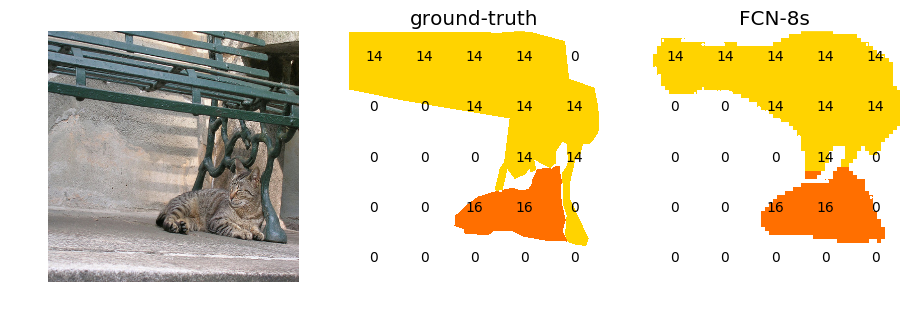

In [15]:
outputs = show_results(image_id=520)